In [2]:
Q = np.array([
    [-1.0, 0.0],
    [0.0, 0.0],
    [1.0, 2.0],
    [3.0, 3.0],
    [4.0, 0.0],
])  # 4 knots => n=3 Bezier segments

In [176]:
Q = np.array([
    [-1.0, 0.0],
    [0.0, -1.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 2.0],
    [0.0, 3.0],
    [0.0, 4.0],
    #[-1.0, 1.0],
    #[0.0, 0.0], ... Closed system => done set endpoint
])  # 4 knots => n=3 Bezier segments

49


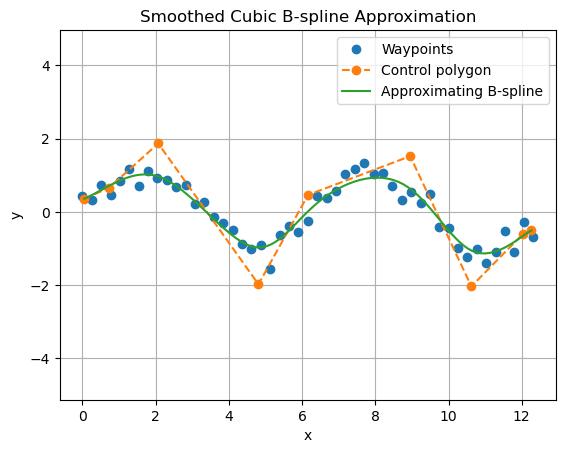

In [533]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Smoothed B-spline approximation (cubic)
# -----------------------

# Waypoints
# Q = np.array([
#     [0.0, 0.0],
#     [1.0, 2.0],
#     [3.0, 3.0],
#     [4.0, 2.0],
#     [5.0, 0.0]
# ])

M = len(Q) - 1
k = 3 #3  # cubic degree

# Step 1: chord-length parameters in [0,1]
dist = np.linalg.norm(np.diff(Q, axis=0), axis=1)
t = np.zeros(M + 1)
t[1:] = np.cumsum(dist)
t /= t[-1]
print(len(t))

# Step 2: fewer control points => approximation not interpolation
n = 8 #4  # n+1 control points
#n = len(Q) - 5

# Step 3: clamped uniform knot vector on [0,1]
U = np.zeros(n + k + 2)
U[-(k+1):] = 1.0
num_interior = n - k
if num_interior > 0:
    interior = np.linspace(0, 1, num_interior + 2)[1:-1]
    U[k+1:k+1+num_interior] = interior

# Cox–de Boor basis with endpoint handling
def N(i, p, x):
    if p == 0:
        # include right endpoint so curve reaches the end
        if (U[i] <= x < U[i+1]) or (x == U[-1] and U[i] <= x <= U[i+1]):
            return 1.0
        return 0.0

    denom1 = U[i+p] - U[i]
    denom2 = U[i+p+1] - U[i+1]
    term1 = 0.0
    term2 = 0.0
    if denom1 > 1e-12:
        term1 = (x - U[i]) / denom1 * N(i, p-1, x)
    if denom2 > 1e-12:
        term2 = (U[i+p+1] - x) / denom2 * N(i+1, p-1, x)
    return term1 + term2

# Step 4: build basis matrix A
A = np.zeros((M + 1, n + 1))
for j in range(M + 1):
    for i in range(n + 1):
        A[j, i] = N(i, k, t[j])

# Step 5: smoothing penalty on 2nd differences
lam = 1e-2 #1e-2
D2 = np.zeros((n - 1, n + 1))
for i in range(n - 1):
    D2[i, i]     = 1.0
    D2[i, i + 1] = -2.0
    D2[i, i + 2] = 1.0

# Solve (A^T A + lam D^T D) P = A^T Q
P = np.linalg.solve(A.T @ A + lam * (D2.T @ D2), A.T @ Q)

# Evaluate spline
T = np.linspace(0, 1, 100)
curve = np.zeros((len(T), 2))
for ti, tt in enumerate(T):
    for i in range(n + 1):
        curve[ti] += N(i, k, tt) * P[i]

# Plot
plt.figure()
plt.plot(Q[:, 0], Q[:, 1], 'o', label="Waypoints")
plt.plot(P[:, 0], P[:, 1], '--o', label="Control polygon")
plt.plot(curve[:, 0], curve[:, 1], label="Approximating B-spline")
plt.title("Smoothed Cubic B-spline Approximation")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()


In [534]:
data_a = {'k':k, 'n':n, 'M':M, 't':t, 'U':U, 'P':P, 'T':T, 'curve':curve}

In [19]:
print(U)

[0.   0.   0.   0.   0.25 0.5  0.75 1.   1.   1.   1.  ]


In [26]:
M

6

13

In [116]:
Q = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 2.0],
    [-1.0, 1.0],
    #[-0.75, 0.5],
    #[-0.25, 0.75],
    #[0.0, 0.0],
])

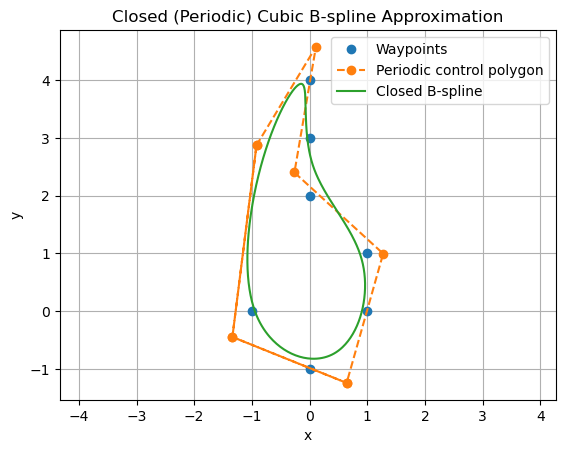

In [146]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Closed (periodic) cubic B-spline approximation
# -----------------------

# Example closed-loop waypoints (replace with yours)
# Q = np.array([
#     [0.0, 0.0],
#     [1.5, 2.0],
#     [3.5, 2.5],
#     [5.0, 0.5],
#     [4.0, -2.0],
#     [2.0, -2.5],
#     [0.5, -1.5]
# ])

# Ensure closed data (append first point if needed)
if np.linalg.norm(Q[0] - Q[-1]) > 1e-9:
    Q = np.vstack([Q, Q[0]])

M = len(Q) - 1  # last equals first
k = 3           # cubic

# Step 1: chord-length parameters around the loop, normalized to [0,1)
dist = np.linalg.norm(np.diff(Q, axis=0), axis=1)
s = np.zeros(M + 1)
s[1:] = np.cumsum(dist)
t = s / s[-1]
t = t[:-1]      # drop duplicated last point; t in [0,1)

Q_data = Q[:-1]

# Step 2: choose number of control points (more = closer fit)
Ncp = 9 #8
assert Ncp > k

# Periodicity constraint: last k control points are copies of first k
Nind = Ncp - k   # independent control points

# Step 3: uniform *non-clamped* knot vector
U = np.arange(Ncp + k + 2, dtype=float)

# Parameter domain for basis is [U[k], U[Ncp]]
t_eval = U[k] + t * (U[Ncp] - U[k])

# Cox–de Boor basis
def N(i, p, x):
    if p == 0:
        return 1.0 if (U[i] <= x < U[i+1]) else 0.0
    denom1 = U[i+p] - U[i]
    denom2 = U[i+p+1] - U[i+1]
    term1 = 0.0
    term2 = 0.0
    if denom1 > 1e-12:
        term1 = (x - U[i]) / denom1 * N(i, p-1, x)
    if denom2 > 1e-12:
        term2 = (U[i+p+1] - x) / denom2 * N(i+1, p-1, x)
    return term1 + term2

# Step 4: Build full basis matrix A for all Ncp control points
A_full = np.zeros((len(t_eval), Ncp))
for j, tj in enumerate(t_eval):
    for i in range(Ncp):
        A_full[j, i] = N(i, k, tj)

# Merge tied columns -> matrix for independent control points
A_hat = A_full[:, :Nind].copy()
for j in range(k):
    A_hat[:, j] += A_full[:, Nind + j]

# Step 5: cyclic smoothing penalty (second differences, wrap-around)
lam = 1e-2
D2 = np.zeros((Nind, Nind))
for i in range(Nind):
    D2[i, i] = 1.0
    D2[i, (i+1) % Nind] = -2.0
    D2[i, (i+2) % Nind] = 1.0

# Solve regularized least squares
P_ind = np.linalg.solve(
    A_hat.T @ A_hat + lam * (D2.T @ D2),
    A_hat.T @ Q_data
)

# Reconstruct full periodic control points
P = np.vstack([P_ind, P_ind[:k]])

# Evaluate spline densely (endpoint=False keeps it periodic)
T = np.linspace(U[k], U[Ncp], 400, endpoint=False)
curve = np.zeros((len(T), 2))
for ti, tt in enumerate(T):
    for i in range(Ncp):
        curve[ti] += N(i, k, tt) * P[i]

# Plot
plt.figure()
plt.plot(Q_data[:, 0], Q_data[:, 1], 'o', label="Waypoints")
plt.plot(P[:, 0], P[:, 1], '--o', label="Periodic control polygon")
plt.plot(curve[:, 0], curve[:, 1], label="Closed B-spline")
plt.axis('equal')
plt.title("Closed (Periodic) Cubic B-spline Approximation")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()


In [60]:
Q = np.array([
    [-1.0, 0.0],
    [0.0, -0.25],
    [1.0, 0.2],
    [2.0, 0.5],
    [3.0, 0.3],
    [4.0, 1.2],
    [5.0, 1.0],
    [5.5, 1.4],
    [5.8, 1.8],
    [5.4, 2.1],
    [5.6, 2.3],
    [5.2, 2.6],
    [5.1, 3.0],
])  

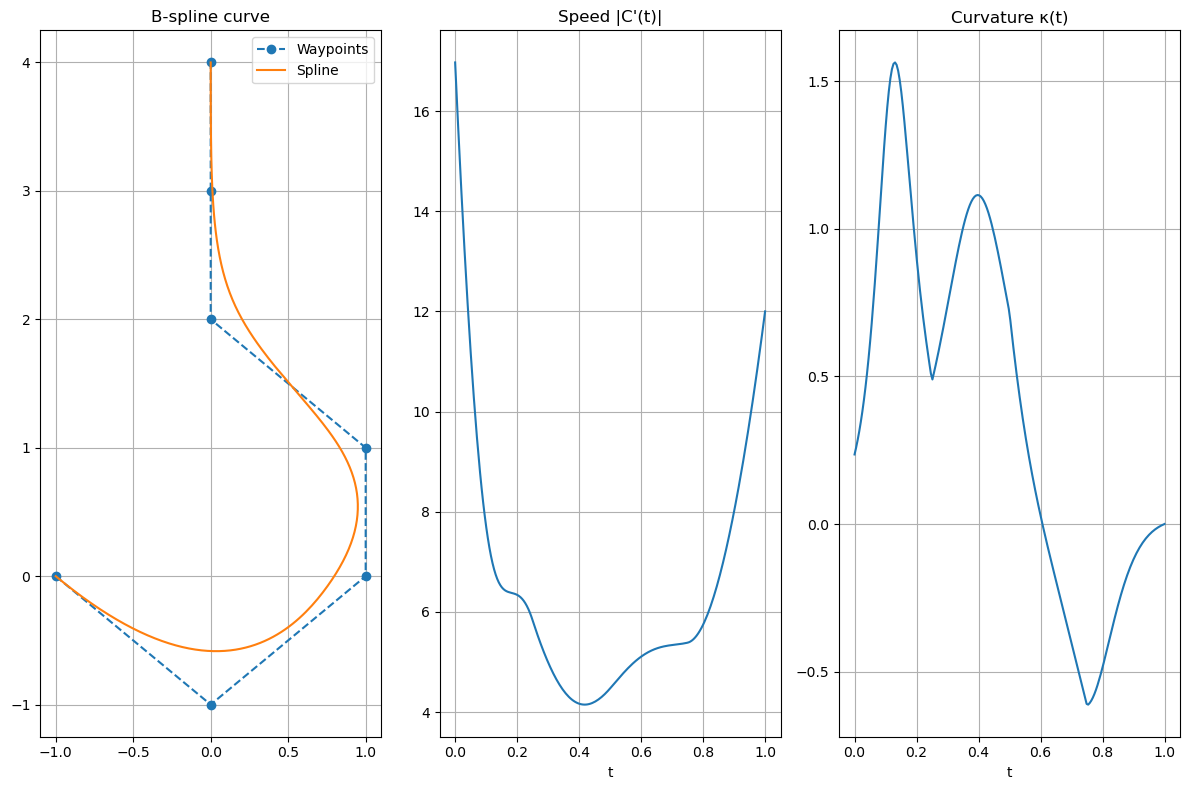

In [143]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# B-spline basis and evaluation
# -------------------------------

# def bspline_basis(i, k, t, knots):
#     """Cox–de Boor recursion for scalar t."""
#     if k == 0:
#         return 1.0 if (knots[i] <= t < knots[i+1]) else 0.0
#     denom1 = knots[i+k]   - knots[i]
#     denom2 = knots[i+k+1] - knots[i+1]
#     term1 = 0.0
#     term2 = 0.0
#     if denom1 > 1e-14:
#         term1 = (t - knots[i]) / denom1 * bspline_basis(i, k-1, t, knots)
#     if denom2 > 1e-14:
#         term2 = (knots[i+k+1] - t) / denom2 * bspline_basis(i+1, k-1, t, knots)
#     return term1 + term2

def bspline_basis(i, k, t, knots):
    """Cox–de Boor recursion for scalar t (fixed endpoint handling)."""
    if k == 0:
        # Include the right endpoint in the last knot span
        if (knots[i] <= t < knots[i+1]) or (
            t == knots[-1] and knots[i] <= t <= knots[i+1]
        ):
            return 1.0
        return 0.0
    denom1 = knots[i+k]   - knots[i]
    denom2 = knots[i+k+1] - knots[i+1]
    term1 = term2 = 0.0
    if denom1 > 1e-14:
        term1 = (t - knots[i]) / denom1 * bspline_basis(i, k-1, t, knots)
    if denom2 > 1e-14:
        term2 = (knots[i+k+1] - t) / denom2 * bspline_basis(i+1, k-1, t, knots)
    return term1 + term2

def eval_bspline(t, control_points, degree, knots):
    """Evaluate B-spline curve C(t) for scalar t."""
    control_points = np.asarray(control_points, dtype=float)
    n = len(control_points) - 1
    d = control_points.shape[1]
    C = np.zeros(d)
    for i in range(n + 1):
        Ni = bspline_basis(i, degree, t, knots)
        C += Ni * control_points[i]
    return C


# -------------------------------
# Derivatives via derivative control nets
# -------------------------------

def derivative_control_points(control_points, degree, knots):
    """
    Compute control points and knot vector of the first derivative spline.
    Returns (new_control_points, new_degree, new_knots).
    """
    control_points = np.asarray(control_points, dtype=float)
    n = len(control_points) - 1
    d = control_points.shape[1]

    new_cps = []
    for i in range(n):
        denom = knots[i + degree + 1] - knots[i + 1]
        if abs(denom) < 1e-14:
            new_cps.append(np.zeros(d))
        else:
            new_cps.append(degree * (control_points[i+1] - control_points[i]) / denom)

    # derivative knot vector drops first and last knot
    new_knots = knots[1:-1]
    return np.array(new_cps), degree - 1, new_knots


def eval_bspline_and_derivatives(t, control_points, degree, knots, order=2):
    """
    Evaluate B-spline and its derivatives up to given order at scalar t.
    Returns a list [C, C', C'', ...] of length order+1.
    """
    results = []
    cps = np.asarray(control_points, dtype=float)
    deg = degree
    kts = np.asarray(knots, dtype=float)

    # 0th derivative (the curve itself)
    results.append(eval_bspline(t, cps, deg, kts))

    # higher derivatives
    for _ in range(order):
        if deg <= 0:
            # no higher derivatives of a degree-0 spline
            results.append(np.zeros_like(results[-1]))
            continue
        cps, deg, kts = derivative_control_points(cps, deg, kts)
        results.append(eval_bspline(t, cps, deg, kts))

    return results  # [C, C', C'', ...]


# -------------------------------
# Curvature (2D or 3D)
# -------------------------------

# def curvature_from_derivatives(C1, C2):
#     """Compute curvature κ from first and second derivatives."""
#     C1 = np.asarray(C1, dtype=float)
#     C2 = np.asarray(C2, dtype=float)

#     if C1.shape[0] == 2:
#         # 2D: κ = |x'y'' - y'x''| / (x'^2 + y'^2)^(3/2)
#         x1, y1 = C1
#         x2, y2 = C2
#         num = x1 * y2 - y1 * x2
#         den = (x1**2 + y1**2) ** 1.5
#         if den == 0:
#             return 0.0
#         return abs(num) / den
#     else:
#         # 3D: κ = |v × a| / |v|^3
#         num = np.linalg.norm(np.cross(C1, C2))
#         den = np.linalg.norm(C1) ** 3
#         if den == 0:
#             return 0.0
#        return num / den

def curvature_from_derivatives(C1, C2, signed=True):
    C1 = np.asarray(C1)
    C2 = np.asarray(C2)
    if C1.shape[0] == 2:  # 2D
        x1, y1 = C1
        x2, y2 = C2
        num = x1 * y2 - y1 * x2
        den = (x1**2 + y1**2) ** 1.5
        if den == 0:
            return 0.0
        kappa = num / den
        return kappa if signed else abs(kappa)
    else:
        num = np.linalg.norm(np.cross(C1, C2))
        den = np.linalg.norm(C1) ** 3
        if den == 0:
            return 0.0
        kappa = num / den
        return kappa if signed else abs(kappa)


# -------------------------------
# Demo: cubic open-uniform spline in 2D
# -------------------------------

if __name__ == "__main__":
    degree = 3 #3  # cubic

    # Control points (2D)
    control_points = np.array([
        [0.0, 0.0],
        [1.0, 2.0],
        [3.0, 3.0],
        [4.0, 1.0],
        [5.0, 0.0]
    ])
    control_points = Q

    n = len(control_points) - 1

    # Open-uniform knot vector on [0,1]
    knots = np.zeros(n + degree + 2)
    knots[-(degree+1):] = 1.0
    num_interior = n - degree
    if num_interior > 0:
        interior = np.linspace(0, 1, num_interior + 2)[1:-1]
        knots[degree+1:degree+1+num_interior] = interior

    # Sample along the valid parameter range
    Ts = np.linspace(knots[degree], knots[-degree-1], 200)

    curve = []
    vel = []
    acc = []
    curv = []

    for t in Ts:
        C, C1, C2 = eval_bspline_and_derivatives(
            t, control_points, degree, knots, order=2
        )
        curve.append(C)
        vel.append(C1)
        acc.append(C2)
        curv.append(curvature_from_derivatives(C1, C2))

    curve = np.array(curve)
    vel = np.array(vel)
    acc = np.array(acc)
    curv = np.array(curv)

    # -----------------------
    # Plots
    # -----------------------
    fig, axes = plt.subplots(1, 3, figsize=(12, 8))

    # Curve and control polygon
    ax0 = axes[0]
    ax0.plot(control_points[:, 0], control_points[:, 1], '--o', label="Waypoints")
    ax0.plot(curve[:, 0], curve[:, 1], label="Spline")
    ax0.set_title("B-spline curve")
    #ax0.set_aspect('equal', 'box')
    ax0.grid(True)
    ax0.legend()

    # Speed |C'(t)|
    speed = np.linalg.norm(vel, axis=1)
    ax1 = axes[1]
    ax1.plot(Ts, speed)
    ax1.set_title("Speed |C'(t)|")
    ax1.set_xlabel("t")
    ax1.grid(True)

    # Curvature κ(t)
    ax2 = axes[2]
    ax2.plot(Ts, curv)
    ax2.set_title("Curvature κ(t)")
    ax2.set_xlabel("t")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [82]:
Q = np.array([
    [-1.0, 0.0],
    [0.0, -0.25],
    [1.0, 0.2],
    [2.0, 0.5],
    [3.0, 0.3],
    [4.0, 1.2],
    [5.0, 1.0],
    [5.5, 1.4],
    [5.8, 1.8],
    [5.4, 2.1],
    [5.6, 2.3],
    [5.2, 2.6],
    [5.1, 3.0],
])  

n = 5


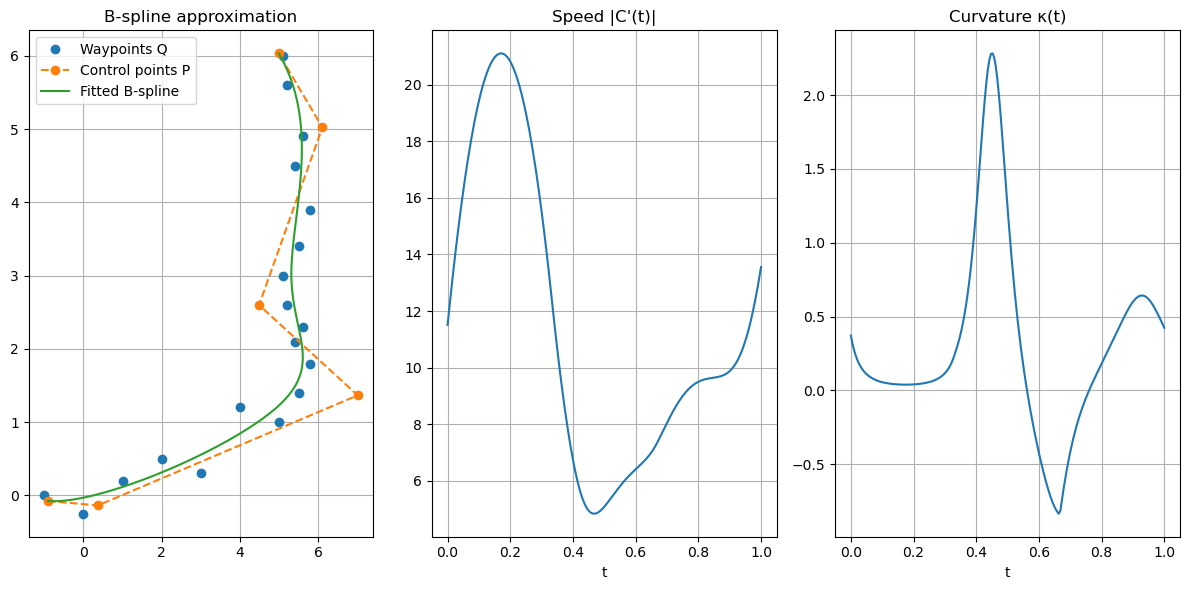

Query point P = [5.5 3.5]
Closest parameter t* = 0.7330391921177482
Closest point C(t*) = [5.37820338 3.52618215]
Distance = 0.12457897434855955


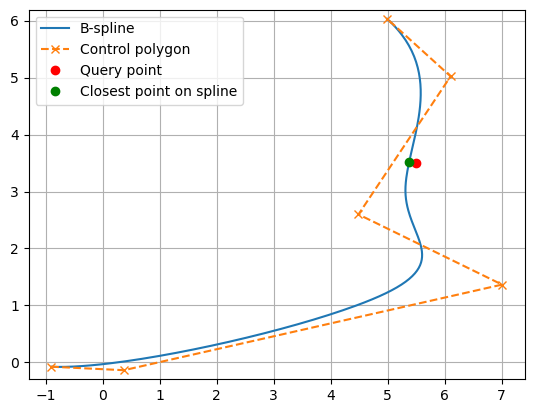

In [136]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# B-spline basis and evaluation
# -------------------------------

def bspline_basis(i, k, t, knots):
    """Cox–de Boor recursion for scalar t (fixed endpoint handling)."""
    if k == 0:
        # Include the right endpoint in the last knot span
        if (knots[i] <= t < knots[i+1]) or (
            t == knots[-1] and knots[i] <= t <= knots[i+1]
        ):
            return 1.0
        return 0.0

    denom1 = knots[i + k]   - knots[i]
    denom2 = knots[i + k+1] - knots[i+1]
    term1 = term2 = 0.0

    if denom1 > 1e-14:
        term1 = (t - knots[i]) / denom1 * bspline_basis(i, k-1, t, knots)
    if denom2 > 1e-14:
        term2 = (knots[i + k+1] - t) / denom2 * bspline_basis(i+1, k-1, t, knots)

    return term1 + term2


def eval_bspline(t, control_points, degree, knots):
    """Evaluate B-spline curve C(t) for scalar t."""
    control_points = np.asarray(control_points, dtype=float)
    n = len(control_points) - 1
    d = control_points.shape[1]
    C = np.zeros(d)
    for i in range(n + 1):
        Ni = bspline_basis(i, degree, t, knots)
        C += Ni * control_points[i]
    return C


# -------------------------------
# Derivatives via derivative control nets
# -------------------------------

def derivative_control_points(control_points, degree, knots):
    """
    Compute control points and knot vector of the first derivative spline.
    Returns (new_control_points, new_degree, new_knots).
    """
    control_points = np.asarray(control_points, dtype=float)
    n = len(control_points) - 1
    d = control_points.shape[1]

    new_cps = []
    for i in range(n):
        denom = knots[i + degree + 1] - knots[i + 1]
        if abs(denom) < 1e-14:
            new_cps.append(np.zeros(d))
        else:
            new_cps.append(degree * (control_points[i+1] - control_points[i]) / denom)

    # derivative knot vector drops first and last knot
    new_knots = knots[1:-1]
    return np.array(new_cps), degree - 1, new_knots


def eval_bspline_and_derivatives(t, control_points, degree, knots, order=2):
    """
    Evaluate B-spline and its derivatives up to given order at scalar t.
    Returns a list [C, C', C'', ...] of length order+1.
    """
    results = []
    cps = np.asarray(control_points, dtype=float)
    deg = degree
    kts = np.asarray(knots, dtype=float)

    # 0th derivative (the curve itself)
    results.append(eval_bspline(t, cps, deg, kts))

    # higher derivatives
    for _ in range(order):
        if deg <= 0:
            # no higher derivatives of a degree-0 spline
            results.append(np.zeros_like(results[-1]))
            continue
        cps, deg, kts = derivative_control_points(cps, deg, kts)
        results.append(eval_bspline(t, cps, deg, kts))

    return results  # [C, C', C'', ...]


# -------------------------------
# Curvature (2D or 3D)
# -------------------------------

def curvature_from_derivatives(C1, C2, signed=True):
    C1 = np.asarray(C1, dtype=float)
    C2 = np.asarray(C2, dtype=float)

    if C1.shape[0] == 2:  # 2D
        x1, y1 = C1
        x2, y2 = C2
        num = x1 * y2 - y1 * x2
        den = (x1**2 + y1**2) ** 1.5
        if den == 0:
            return 0.0
        kappa = num / den
        return kappa if signed else abs(kappa)
    else:
        # 3D: κ = |v × a| / |v|^3
        num = np.linalg.norm(np.cross(C1, C2))
        den = np.linalg.norm(C1) ** 3
        if den == 0:
            return 0.0
        kappa = num / den
        return kappa if signed else abs(kappa)


# -------------------------------
# Fit B-spline control points from waypoints (least squares)
# -------------------------------

def fit_bspline_least_squares(Q, degree, n):
    """
    Given waypoints Q (M x d), degree, and n (so n+1 control points),
    solve for control points P in a least-squares sense:
        C(t_j) ≈ Q_j

    Returns:
        control_points (P: (n+1, d)), knots
    """
    Q = np.asarray(Q, dtype=float)
    M, d = Q.shape

    if n < degree:
        raise ValueError("n must be >= degree for a valid B-spline.")

    num_cps = n + 1

    # Open-uniform knot vector on [0, 1]
    # len(knots) = n + degree + 2 = num_cps + degree + 1
    knots = np.zeros(num_cps + degree + 1)
    knots[-(degree+1):] = 1.0

    num_interior = num_cps - degree - 1  # = n - degree
    if num_interior > 0:
        interior = np.linspace(0.0, 1.0, num_interior + 2)[1:-1]
        knots[degree+1:degree+1+num_interior] = interior

    # Parameter values for waypoints (simple uniform parametrization)
    ts = np.linspace(0.0, 1.0, M)

    # Build basis matrix A (M x num_cps)
    A = np.zeros((M, num_cps))
    for j, t in enumerate(ts):
        for i in range(num_cps):
            A[j, i] = bspline_basis(i, degree, t, knots)

    # Least-squares solve: A @ P ≈ Q  -> P shape: (num_cps, d)
    P, *_ = np.linalg.lstsq(A, Q, rcond=None)

    # Reconstruct full periodic control points
    #P = np.vstack([P, P[:degree]])

    return P, knots

def closest_point_on_bspline(
    P,
    control_points,
    degree,
    knots,
    num_initial_samples=200,
    max_iter=20,
    tol=1e-6
):
    """
    Find the closest point on a B-spline curve to a given point P.

    Returns:
        t_closest : parameter value
        C_closest : point on the curve C(t_closest)
        dist      : Euclidean distance ||C(t_closest) - P||
    """
    P = np.asarray(P, dtype=float)
    control_points = np.asarray(control_points, dtype=float)
    knots = np.asarray(knots, dtype=float)

    # Valid parameter range for your clamped B-spline
    t_min = knots[degree]
    t_max = knots[-degree-1]

    # --- 1) Coarse sampling to get a good initial guess ---
    Ts = np.linspace(t_min, t_max, num_initial_samples)
    dists2 = []
    for t in Ts:
        C = eval_bspline(t, control_points, degree, knots)
        r = C - P
        dists2.append(np.dot(r, r))
    dists2 = np.array(dists2)
    t0 = Ts[np.argmin(dists2)]

    # --- 2) Newton refinement on g(t) = (C(t)-P)·C'(t) ---
    t = t0
    for _ in range(max_iter):
        C, C1, C2 = eval_bspline_and_derivatives(
            t, control_points, degree, knots, order=2
        )
        r = C - P

        # g(t) and g'(t)
        g = np.dot(r, C1)
        gprime = np.dot(C1, C1) + np.dot(r, C2)

        if abs(gprime) < 1e-14:
            break  # avoid division by zero / flat derivative

        t_new = t - g / gprime
        # Clamp to valid interval
        t_new = max(t_min, min(t_max, t_new))

        if abs(t_new - t) < tol:
            t = t_new
            break
        t = t_new

    # Final closest point and distance
    C_closest = eval_bspline(t, control_points, degree, knots)
    dist = np.linalg.norm(C_closest - P)
    return t, C_closest, dist



# -------------------------------
# Demo: pass waypoints Q and choose n
# -------------------------------

if __name__ == "__main__":
    degree = 3 #3  # cubic

    # Waypoints Q (2D). These are NOT the control points anymore.
    # Q = np.array([
    #     [0.0, 0.0],
    #     [1.0, 2.0],
    #     [3.0, 3.0],
    #     [4.0, 1.0],
    #     [5.0, 0.0]
    # ])

    # Choose n: number of control points = n + 1
    # You can change this to see how approximation smoothness changes.
    n = 4   # -> 5 control points
    n = max(int(len(Q)*0.3), degree)
    #n = degree
    print('n =', n)

    # Fit control points from waypoints
    control_points, knots = fit_bspline_least_squares(Q, degree, n)

    # Sample along parameter range
    Ts = np.linspace(knots[degree], knots[-degree-1], 200)

    curve = []
    vel = []
    acc = []
    curv = []

    for t in Ts:
        C, C1, C2 = eval_bspline_and_derivatives(
            t, control_points, degree, knots, order=2
        )
        curve.append(C)
        vel.append(C1)
        acc.append(C2)
        curv.append(curvature_from_derivatives(C1, C2))

    curve = np.array(curve)
    vel = np.array(vel)
    acc = np.array(acc)
    curv = np.array(curv)

    # -----------------------
    # Plots
    # -----------------------
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    # Curve, control polygon, and waypoints
    ax0 = axes[0]
    ax0.plot(Q[:, 0], Q[:, 1], 'o', label="Waypoints Q")
    ax0.plot(control_points[:, 0], control_points[:, 1], '--o', label="Control points P")
    ax0.plot(curve[:, 0], curve[:, 1], label="Fitted B-spline")
    ax0.set_title("B-spline approximation")
    ax0.grid(True)
    #ax0.set_aspect('equal', 'box')
    ax0.legend()

    # Speed |C'(t)|
    speed = np.linalg.norm(vel, axis=1)
    ax1 = axes[1]
    ax1.plot(Ts, speed)
    ax1.set_title("Speed |C'(t)|")
    ax1.set_xlabel("t")
    ax1.grid(True)
    #ax1.set_aspect('equal', 'box')

    # Curvature κ(t)
    ax2 = axes[2]
    ax2.plot(Ts, curv)
    ax2.set_title("Curvature κ(t)")
    ax2.set_xlabel("t")
    ax2.grid(True)
    #ax2.set_aspect('equal', 'box')

    plt.tight_layout()
    plt.show()


    # Query point
    P = np.array([5.5, 3.5])

    t_star, C_star, d_star = closest_point_on_bspline(
        P, control_points, degree, knots
    )

    print("Query point P =", P)
    print("Closest parameter t* =", t_star)
    print("Closest point C(t*) =", C_star)
    print("Distance =", d_star)

    plt.figure()
    plt.plot(curve[:, 0], curve[:, 1], label="B-spline")
    plt.plot(control_points[:, 0], control_points[:, 1], '--x', label="Control polygon")
    plt.plot(P[0], P[1], 'ro', label="Query point")
    plt.plot(C_star[0], C_star[1], 'go', label="Closest point on spline")
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()


In [167]:
Q = np.array([
    [-1.0, 0.0],
    [0.0, -0.25],
    [1.0, 0.2],
    [2.0, 0.5],
    [3.0, 0.3],
    [4.0, 1.2],
    [5.0, 1.0],
    [5.5, 1.4],
    [5.8, 1.8],
    [5.4, 2.1],
    [5.6, 2.3],
    [5.2, 2.6],
    [5.1, 3.0],
    [5.5, 3.4],
    [5.8, 3.9],
    [5.4, 4.5],
    [5.6, 4.9],
    [5.2, 5.6],
    [5.1, 6.0],
]) 

In [210]:
Q = np.array([
    [0.0000,  0.4410],
    [0.2565,  0.3352],
    [0.5130,  0.7424],
    [0.7695,  0.4475],
    [1.0260,  0.8478],
    [1.2825,  1.1676],
    [1.5390,  0.6984],
    [1.7955,  1.1204],
    [2.0520,  0.9168],
    [2.3085,  0.8751],
    [2.5650,  0.6779],
    [2.8215,  0.7389],
    [3.0780,  0.2214],
    [3.3345,  0.2633],
    [3.5910, -0.1391],
    [3.8475, -0.3032],
    [4.1040, -0.4864],
    [4.3605, -0.8731],
    [4.6170, -1.0050],
    [4.8735, -0.9128],
    [5.1300, -1.5484],
    [5.3865, -0.6231],
    [5.6430, -0.3846],
    [5.8995, -0.5604],
    [6.1560, -0.2486],
    [6.4125,  0.4450],
    [6.6690,  0.3924],
    [6.9255,  0.5591],
    [7.1820,  1.0441],
    [7.4385,  1.1587],
    [7.6950,  1.3322],
    [7.9515,  1.0394],
    [8.2080,  1.0714],
    [8.4645,  0.7056],
    [8.7210,  0.3324],
    [8.9775,  0.5485],
    [9.2340,  0.2354],
    [9.4905,  0.4888],
    [9.7470, -0.4153],
    [10.0035, -0.4358],
    [10.2600, -0.9973],
    [10.5165, -1.2247],
    [10.7730, -1.0200],
    [11.0295, -1.3963],
    [11.2860, -1.1008],
    [11.5425, -0.5101],
    [11.7990, -1.0884],
    [12.0555, -0.2857],
    [12.3120, -0.6781]
])


In [211]:
len(Q)

49

# Affine transformation for T and U (normalization to [0,1])

49
cnt= 188


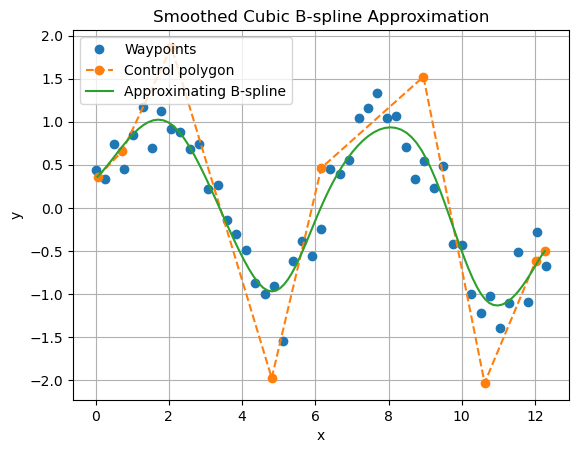

In [557]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Smoothed B-spline approximation (cubic)
# -----------------------

# Waypoints
# Q = np.array([
#     [0.0, 0.0],
#     [1.0, 2.0],
#     [3.0, 3.0],
#     [4.0, 2.0],
#     [5.0, 0.0]
# ])

M = len(Q) - 1
k = 3  # cubic degree

# ---------------------------------------------------
# Step 1: chord-length parameters (RAW + normalization)
# ---------------------------------------------------
# Step 1: chord-length parameters in [0,1]
dist = np.linalg.norm(np.diff(Q, axis=0), axis=1)
# centripetal 
#dist = np.sqrt(dist)

# raw parameter vector in chord-length space
t_raw = np.zeros(M + 1)
t_raw[1:] = np.cumsum(dist)

# normalization parameters for t_raw -> [0, 1]
t_min = t_raw[0]
t_max = t_raw[-1]
scale = 1.0 / (t_max - t_min) if t_max > t_min else 1.0
offset = -t_min * scale  # general form, here t_min is usually 0

# normalized parameter vector in [0, 1]
t = t_raw * scale + offset

print(len(t))

# --------------------------------------------
# Step 2: choose number of control points
# --------------------------------------------
n = k+1  # n+1 control points (approximation, not interpolation)
#n = len(Q) - 1
n = max(int(len(Q)*0.2), k)
n=8

# ---------------------------------------------------------
# Step 3: clamped uniform *RAW* knot vector, then normalize
# ---------------------------------------------------------
# Build a raw knot vector U_raw on the same raw domain [t_min, t_max]
U_raw = np.zeros(n + k + 2)
U_raw[:(k+1)] = t_min
U_raw[-(k + 1):] = t_max  # clamp to raw max

num_interior = n - k
if num_interior > 0:
    # interior knots evenly spaced in the raw parameter domain
    interior_raw = np.linspace(t_min, t_max, num_interior + 2)[1:-1]
    U_raw[k + 1:k + 1 + num_interior] = interior_raw

# Now normalize the knot vector using the SAME affine transform as t_raw -> t
U = U_raw * scale + offset
#U[:(k+1)] = 0
#U[-(k + 1):] = 1
# ---------------------------------------------------------
# Cox–de Boor basis with endpoint handling (uses normalized U)
# ---------------------------------------------------------
cnt = 0
def N(i, p, x):
    global cnt, k
    if p==k:
        cnt += 1
    if p == 0:
        # include right endpoint so curve reaches the end
        if (U[i] <= x < U[i + 1]): # or (x==U[-1] and U[i] <= x <= U[i + 1]):
            return 1.0
        return 0.0

    denom1 = U[i + p] - U[i]
    denom2 = U[i + p + 1] - U[i + 1]
    term1 = 0.0
    term2 = 0.0
    if denom1 > 1e-12:
        term1 = (x - U[i]) / denom1 * N(i, p - 1, x)
    if denom2 > 1e-12:
        term2 = (U[i + p + 1] - x) / denom2 * N(i + 1, p - 1, x)
    return term1 + term2

# --------------------------------------------
# Step 4: build basis matrix A
# --------------------------------------------
A = np.zeros((M + 1, n + 1))
# for j in range(M + 1):
#     for i in range(n + 1):
#         #if (U[i]<=t[j]) and (t[j]<=U[i+k+1]) or ((j==M) and (i>=n-k)):
#         A[j, i] = N(i, k, t[j])
A[0][0] = 1.0
A[M][n] = 1.0
for j in range(1, M):
    for i in range(n + 1):
        #cnt +=1
        if (U[i]<=t[j]) and (t[j]<=U[i+k+1]):
            A[j, i] = N(i, k, t[j])

# --------------------------------------------
# Step 5: smoothing penalty on 2nd differences
# --------------------------------------------
lam = 1e-2 #1e-2
D2 = np.zeros((n - 1, n + 1))
for i in range(n - 1):
    D2[i, i]     = 1.0
    D2[i, i + 1] = -2.0
    D2[i, i + 2] = 1.0

# Solve (A^T A + lam D^T D) P = A^T Q
# if lam < 1e-6:
#     P = np.linalg.solve(A.T @ A, A.T @ Q)
# else:
#     P = np.linalg.solve(A.T @ A + lam * (D2.T @ D2), A.T @ Q)
if lam < 1e-6:
    # Unregularized least squares
    P, *_ = np.linalg.lstsq(A, Q, rcond=None)
else:
    # Build stacked system
    A_tilde = np.vstack([
        A,
        np.sqrt(lam) * D2
    ])
    Q_tilde = np.vstack([
        Q,
        np.zeros((D2.shape[0], Q.shape[1] if Q.ndim > 1 else 1))
    ])
    # Solve least squares
    P, *_ = np.linalg.lstsq(A_tilde, Q_tilde, rcond=None)

#P = np.linalg.solve(A.T @ A + lam * (D2.T @ D2), A.T @ Q)
# --------------------------------------------
# Step 6: evaluate spline (in normalized domain [0,1])
# --------------------------------------------
print('cnt=', cnt)

T = np.linspace(0, 1, 100)
curve = np.zeros((len(T), 2))
for ti, tt in enumerate(T):
    for i in range(n + 1):
        if (U[i]<=tt) and (tt<=U[i+k+1]):
            curve[ti] += N(i, k, tt) * P[i]

curve[-1] = P[-1]


# P = np.linalg.solve(A.T @ A + lam * (D2.T @ D2), A.T @ Q)
# Evaluate spline
# T = np.linspace(0, 1, 100)
# curve = np.zeros((len(T), 2))
# for ti, tt in enumerate(T):
#     for i in range(n + 1):
#         curve[ti] += N(i, k, tt) * P[i]        

# --------------------------------------------
# Plot
# --------------------------------------------
plt.figure()
plt.plot(Q[:, 0], Q[:, 1], 'o', label="Waypoints")
plt.plot(P[:, 0], P[:, 1], '--o', label="Control polygon")
plt.plot(curve[:, 0], curve[:, 1], label="Approximating B-spline")
plt.title("Smoothed Cubic B-spline Approximation")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
#plt.axis("equal")
plt.legend()
plt.show()


In [558]:
data_b = {'k':k, 'n':n, 'M':M, 't':t, 'U':U, 'P':P, 'T':T, 'curve':curve}

In [548]:
data_a['t'] - data_b['t']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [549]:
data_a['U'] - data_b['U']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [550]:
data_a['P'] - data_b['P']

array([[-0.,  0.],
       [-0., -0.],
       [-0.,  0.],
       [ 0., -0.],
       [-0., -0.],
       [-0.,  0.],
       [-0.,  0.],
       [ 0., -0.],
       [-0.,  0.]])

In [559]:
np.sum(data_a['curve'] - data_b['curve'])

np.float64(-7.934000678666564e-13)

In [522]:
print(k)
print(n)
print(t)
print(U)
print(len(curve))
print(curve[:3])
print(curve[-3:])

3
8
[0.    0.013 0.036 0.055 0.078 0.097 0.123 0.146 0.162 0.174 0.19  0.203
 0.23  0.243 0.265 0.28  0.295 0.317 0.331 0.344 0.377 0.423 0.439 0.454
 0.474 0.509 0.521 0.536 0.562 0.576 0.59  0.609 0.621 0.643 0.664 0.68
 0.7   0.717 0.762 0.774 0.804 0.82  0.836 0.858 0.876 0.907 0.937 0.978
 1.   ]
[0.    0.    0.    0.    0.167 0.333 0.5   0.667 0.833 1.    1.    1.
 1.   ]
100
[[0.053 0.36 ]
 [0.176 0.417]
 [0.298 0.479]]
[[12.157 -0.569]
 [12.215 -0.531]
 [12.264 -0.505]]


In [531]:
print(k)
print(n)
print(t)
print(U)
print(len(curve))
print(curve[:3])
print(curve[-3:])
#print(len(T))

3
8
[0.    0.013 0.036 0.055 0.078 0.097 0.123 0.146 0.162 0.174 0.19  0.203
 0.23  0.243 0.265 0.28  0.295 0.317 0.331 0.344 0.377 0.423 0.439 0.454
 0.474 0.509 0.521 0.536 0.562 0.576 0.59  0.609 0.621 0.643 0.664 0.68
 0.7   0.717 0.762 0.774 0.804 0.82  0.836 0.858 0.876 0.907 0.937 0.978
 1.   ]
[0.    0.    0.    0.    0.167 0.333 0.5   0.667 0.833 1.    1.    1.
 1.   ]
100
[[0.053 0.36 ]
 [0.176 0.417]
 [0.298 0.479]]
[[12.157 -0.569]
 [12.215 -0.531]
 [ 0.     0.   ]]


In [463]:
t_raw/t_raw[

array([0.   , 0.017, 0.039, 0.059, 0.081, 0.102, 0.125, 0.148, 0.166,
       0.183, 0.201, 0.218, 0.242, 0.258, 0.28 , 0.298, 0.316, 0.338,
       0.355, 0.372, 0.399, 0.43 , 0.449, 0.467, 0.487, 0.515, 0.531,
       0.549, 0.573, 0.59 , 0.608, 0.628, 0.644, 0.666, 0.687, 0.706,
       0.726, 0.746, 0.777, 0.793, 0.818, 0.837, 0.855, 0.877, 0.897,
       0.923, 0.949, 0.978, 1.   ])

In [486]:
curvex = curve

In [489]:
np.sum(curvex-curve)

np.float64(11.759313241530467)

In [497]:
P

array([[ 0.053,  0.36 ],
       [ 0.728,  0.655],
       [ 2.073,  1.868],
       [ 4.81 , -1.977],
       [ 6.164,  0.463],
       [ 8.953,  1.522],
       [10.622, -2.034],
       [12.021, -0.615],
       [12.264, -0.505]])

In [511]:
P

array([[ 0.053,  0.36 ],
       [ 0.728,  0.655],
       [ 2.073,  1.868],
       [ 4.81 , -1.977],
       [ 6.164,  0.463],
       [ 8.953,  1.522],
       [10.622, -2.034],
       [12.021, -0.615],
       [12.264, -0.505]])

In [353]:
cnt

3490

In [354]:
k

3

In [355]:
tn

9

In [418]:
T

array([0.   , 0.003, 0.007, 0.01 , 0.013, 0.017, 0.02 , 0.023, 0.027,
       0.03 , 0.033, 0.037, 0.04 , 0.043, 0.047, 0.05 , 0.054, 0.057,
       0.06 , 0.064, 0.067, 0.07 , 0.074, 0.077, 0.08 , 0.084, 0.087,
       0.09 , 0.094, 0.097, 0.1  , 0.104, 0.107, 0.11 , 0.114, 0.117,
       0.12 , 0.124, 0.127, 0.13 , 0.134, 0.137, 0.14 , 0.144, 0.147,
       0.151, 0.154, 0.157, 0.161, 0.164, 0.167, 0.171, 0.174, 0.177,
       0.181, 0.184, 0.187, 0.191, 0.194, 0.197, 0.201, 0.204, 0.207,
       0.211, 0.214, 0.217, 0.221, 0.224, 0.227, 0.231, 0.234, 0.237,
       0.241, 0.244, 0.247, 0.251, 0.254, 0.258, 0.261, 0.264, 0.268,
       0.271, 0.274, 0.278, 0.281, 0.284, 0.288, 0.291, 0.294, 0.298,
       0.301, 0.304, 0.308, 0.311, 0.314, 0.318, 0.321, 0.324, 0.328,
       0.331, 0.334, 0.338, 0.341, 0.344, 0.348, 0.351, 0.355, 0.358,
       0.361, 0.365, 0.368, 0.371, 0.375, 0.378, 0.381, 0.385, 0.388,
       0.391, 0.395, 0.398, 0.401, 0.405, 0.408, 0.411, 0.415, 0.418,
       0.421, 0.425,

In [419]:
U_raw

array([ 0.   ,  0.   ,  0.   ,  0.   ,  4.449,  8.898, 13.347, 17.796,
       22.245, 26.695, 31.144, 31.144, 31.144, 31.144])

In [420]:
U

array([0.   , 0.   , 0.   , 0.   , 0.143, 0.286, 0.429, 0.571, 0.714,
       0.857, 1.   , 1.   , 1.   , 1.   ])

In [315]:
U.shape

(14,)

In [316]:
t.shape

(49,)

In [317]:
t_min

np.float64(0.0)

In [318]:

t_max

np.float64(31.14363500400651)

In [319]:
D2.shape

(8, 10)

In [320]:
n

9

In [321]:
P.shape

(10, 2)

In [322]:
Q_tilde.shape

(57, 2)

In [411]:
np.set_printoptions(precision=3, suppress=True)
print(A)

[[1.    0.    0.    ... 0.    0.    0.   ]
 [0.011 0.434 0.476 ... 0.    0.    0.   ]
 [0.    0.002 0.28  ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.042 0.    0.   ]
 [0.    0.    0.    ... 0.586 0.242 0.   ]
 [0.    0.    0.    ... 0.    0.    1.   ]]


In [345]:
A.size

490

In [444]:
As = A

In [266]:
def N(i, p, x):
    if p == 0:
        # include right endpoint so curve reaches the end
        if (U[i] <= x < U[i + 1]) or (x == U[-1] and U[i] <= x <= U[i + 1]):
            print('U[{}]='.format(i), U[i])
            print('U[{}]='.format(i+1), U[i+1])
            print('p==0 and return 1')
            return 1.0
        print('p==0 and return 0')
        return 0.0

    print('i=', i)
    denom1 = U[i + p] - U[i]
    denom2 = U[i + p + 1] - U[i + 1]
    print('denom1=', denom1)
    print('denom2=', denom2)
    term1 = 0.0
    term2 = 0.0
    if denom1 > 1e-12:
        term1 = (x - U[i]) / denom1 * N(i, p - 1, x)
    if denom2 > 1e-12:
        term2 = (U[i + p + 1] - x) / denom2 * N(i + 1, p - 1, x)
    print('return=', term1+term2)
    return term1 + term2

In [279]:
N(1,3,0)

i= 1
denom1= 0.14285714285714285
denom2= 0.2857142857142857
i= 1
denom1= 0.0
denom2= 0.14285714285714285
i= 2
denom1= 0.0
denom2= 0.14285714285714285
U[3]= 0.0
U[4]= 0.14285714285714285
p==0 and return 1
return= 1.0
return= 1.0
i= 2
denom1= 0.14285714285714285
denom2= 0.2857142857142857
i= 2
denom1= 0.0
denom2= 0.14285714285714285
U[3]= 0.0
U[4]= 0.14285714285714285
p==0 and return 1
return= 1.0
i= 3
denom1= 0.14285714285714285
denom2= 0.14285714285714285
U[3]= 0.0
U[4]= 0.14285714285714285
p==0 and return 1
p==0 and return 0
return= 0.0
return= 0.0
return= 0.0


np.float64(0.0)

In [452]:
As-A

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.03 , -0.029, -0.001, -0.   ,  0.   ,  0.   ],
       [ 0.021, -0.018, -0.003, -0.   ,  0.   ,  0.   ],
       [ 0.027, -0.021, -0.006, -0.   ,  0.   ,  0.   ],
       [ 0.019, -0.013, -0.006, -0.   ,  0.   ,  0.   ],
       [ 0.021, -0.011, -0.009, -0.001,  0.   ,  0.   ],
       [ 0.009, -0.003, -0.006, -0.001,  0.   ,  0.   ],
       [ 0.004, -0.   , -0.004, -0.   ,  0.   ,  0.   ],
       [ 0.01 ,  0.002, -0.01 , -0.002,  0.   ,  0.   ],
       [ 0.016,  0.008, -0.02 , -0.004,  0.   ,  0.   ],
       [ 0.017,  0.016, -0.027, -0.006,  0.   ,  0.   ],
       [ 0.018,  0.026, -0.036, -0.009,  0.   ,  0.   ],
       [ 0.009,  0.026, -0.026, -0.009,  0.   ,  0.   ],
       [ 0.009,  0.038, -0.033, -0.013,  0.   ,  0.   ],
       [ 0.004,  0.038, -0.028, -0.015,  0.   ,  0.   ],
       [ 0.003,  0.047, -0.029, -0.021,  0.   ,  0.   ],
       [ 0.001,  0.053, -0.028, -0.027,  0.   ,  0.   ],
       [ 0.   ,  0.048, -0.018,

In [ ]:
bb